![Lights, Camera Action!](images/lights_camera_action.png "Lights, Camera Action!")

# Crafting a Successful Movie Studio

**Author:** Seth Schober

## Overview
*** ***

This document explores several essential aspects of success in the film industry through the lens of a company looking to grow into the industry with no prior knowledge. As that is an enormous, complex issue, the issue is broken down into three main components. An understanding of each is a vital step towards understanding success in the film industry.

1. Which genres are most lucrative?
2. What is the relationship between popularity and profitability?
3. How does the selection of a Director impact overall success?

The analysis uses large datasets from IMDb, Rotten Tomatoes, The Movie Database, and The Numbers. Each provides their own distinct value, as will be explained downstream. 

In answering the first and second question, a dataset was aggregated from multiple sources that showed the financial and popular success of each movie alongside the genre. Data was also aggregated on a per-genre basis to get an understanding of the larger picture. The third question used a separate dataset showing solely past performance of directors from a financial perspective. There, unnecessary and outlier data was removed before showing the powerfully direct correlation between the selection of a Director and the overall movie success. 

The results of the analysis show a moderate correlation between profit and popularity. The most lucrative genres were determined to be Adventure, Romance, Animation and Crime. Lastly, the top five Directors were identified as Steven Spielberg, Peter Jackson, Michael Bay, James Cameron, and Christopher Nolan. Importantly, the median profitability of a film produced by one of these directors was roughly twice as high as the median profitability of a film produced by the subsequent 20 top Directors. 

In conclusion, it was determined that choice of genre has a noteworthy impact on the success of a film, and the choice of a Director has a substantial impact on success. It is recommended that business decisions take these factors into account when determining the best possible course of action. 

## Business Problem
***
This analysis seeks to make key determinations about the film industry that could be used as a starting point for a company looking to break into the industry. Specifically, it seeks to identify main factors that should be considered from a strategic standpoint. As a new business without industry knowledge, it is essential to dive deep into existing data to gain valuable insights. They will be discussed in depth below.

From a business perspective, this analysis is essential to creating a profitable operation sustained by positive brand reputation and popularity. 

## Data Understanding

***
The data used in this analysis is all publicly available through the Internet Movie Database (IMDb), Rotten Tomatoes (RT), The Numbers (TN), and The Movie Database (TMDb). They provide extensive historical data about movie performance, as well as reviews, ratings, producers and more. 

The data has been broken into four separate categories: general, financial, reviews, and directors. 
- General data includes names, release data, synopses and more. It comes from IMDb, RT and TN. 
- Financial data includes revenue, budget, domestic/worldwide revenue, and profit. This data comes from The Numbers. 
- Review data is composed of crowdsourced feedback. It is available from RT and TMDb. This data is especially relevant given that consumer feedback is invaluable when investigating the feasibilty of business expansion.
- Data on directors and cast is available from multiple source, though TN is used as the primary source for this analysis.

These data sources will be aggregated as relevant to provide a more comprehensive understanding than could be provided by individual sources alone.

## Data Preparation

***

For the sake of clarity, specific comments about data preparation are made throughout the document, as opposed to listing them here.

**Import standard packages**

These packages will be used throughout the analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf
import statistics

pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

**Import data from external files**

These CSV files contain the data previously downloaded from online. They are all located in the *data* folder of this directory. 

In [2]:
# basic film data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# film review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# basic film data from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# film review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# full dataset from TMDb (The Movie Database)
# largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

# top director metrics from The Numbers
path = os.path.join('data', 'tn.top_directors.csv')
tn_top_directors = pd.read_csv(path, encoding= 'unicode_escape') 
# source: https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-specific-technical-role/director

**Essential data cleaning**

Below is a variety of changes that need to be made in order to maximize usability of the data. The specifics of each cleaning step are not discussed in depth for the sake of brevity.

In [3]:
# Clean data from Rotten Tomatoes
# external csv files contain a simple map between current data and
# reformatted data that can be used later in the analysis

# import Studio cleaning dictionary
path = os.path.join('cleaning_dicts','rt_studios.csv')
df = pd.read_csv(path)
studio_cleanup = dict(zip(df.old, df.new))

# import Ratings cleaning dictionary
path = os.path.join('cleaning_dicts','rt_ratings.csv')
df = pd.read_csv(path)
rating_cleanup = dict(zip(df.old, df.new))


path = os.path.join('cleaning_dicts','rt_directors.csv')
df = pd.read_csv(path)
director_cleanup = dict(zip(df.old, df.new))


# apply cleaning dictionary and drop unused columns
rt_reviews['rating'] = rt_reviews['rating'].map(rating_cleanup)
rt_movie_info['studio'] = rt_movie_info['studio'].map(studio_cleanup).fillna(rt_movie_info['studio'])


# convert Fresh/Rotten column to binary 1/0 (i.e. good/bad)
rt_reviews['fresh'] = rt_reviews['fresh'].map({'fresh':1, 'rotten':0})

# converts "None" values/types to NaN for easier manipulation later
imdb_title_basics.fillna(value=np.nan, inplace=True)
imdb_title_ratings.fillna(value=np.nan, inplace=True)
tmdb_movies.fillna(value=np.nan, inplace=True)
tn_movie_budgets.fillna(value=np.nan, inplace=True)
rt_movie_info.fillna(value=np.nan, inplace=True)
rt_reviews.fillna(value=np.nan, inplace=True)

In [4]:
# Drop unused columns for simplicity downstream

rt_movie_info.drop(['synopsis', 'runtime', 'rating', 'dvd_date', 
                    'currency', 'rating', 'theater_date', 'writer'], 
                     axis=1, inplace=True)

rt_reviews.drop(['review', 'publisher', 'critic', 'top_critic', 'date'], 
                axis=1, inplace=True)

imdb_title_basics.drop(['original_title', 'start_year', 'runtime_minutes']
                       , axis=1, inplace=True)

tmdb_movies.drop(['Unnamed: 0', 'original_title', 'id', 
                  'original_language', 'genre_ids', 'vote_average',
                  'vote_count', 'release_date'], axis=1, inplace=True)

tn_movie_budgets.drop(['id', 'release_date'], axis=1, inplace=True)

**Clean financial data**

Below is the manual scrubbing of monetary data. In most cases, non-numeric values needed to be converted to floats. All data comes from TN.

In [5]:
# rename to make analysis easier to follow
finance = tn_movie_budgets.copy()


# remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',',''))
                     for x in finance['production_budget']] 
domestic_gross = [float(x.replace('$', '').replace(',','')) 
                  for x in finance['domestic_gross']]
worldwide_gross = [float(x.replace('$', '').replace(',','')) 
                   for x in finance['worldwide_gross']]


# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

**Clean genre data**

IMDb provides extensive data categorizing movies into genres. Unfortunately, the format they provide isn't especially convenient for the analysis. The below cell provides the solution. Since movies can be classified into multiple genres, those genres are simple listed, comma separated, in one cell for each more. Below, this information is separated such that each genre is allocated its own column. The values in that column are then binary, representing whether or not the selected movie is categorized in that genre, amongst others.

In [6]:
# gather full list of genres from IMDb database
genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []

# separate comma-separated genres within each cell to generate
# a list of all genres
for g in genres_messy:
    for g_split in g.split(','):
        genres_clean.append(g_split)

# remove duplicates
genres_clean = list(set(genres_clean))
genres_clean.sort()


#create dataframe containing only genre data for each film
df = imdb_title_basics
binary_genres = df.loc[df['genres'].isna() == False].copy()

# create a column for each genre
# assign a binary 1/0 for the film's genre classification
for col in genres_clean:
    binary_genres[col] = [col in x for x in binary_genres['genres']]

**Aggregate data to create one DataFrame containing everything used in the remainder of the analysis**

Use SQL to join data from multiple sources into one cohesive dataset.

In [7]:
# renaming now makes the SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})

# write query
q = ''' SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN binary_genres USING (tconst);'''

# Use SQL to join relevant dataframes
all_data = pysqldf(q)
all_data.drop(['primary_title', 'genres'], axis=1, inplace=True)

## Data Analysis Phase 1: The Impact of Genre

This phase of the analysis explores how performance varies by genre. Performance is measured in terms of popularity ratings, as provided by TMDB, and overall profit generation. 

Note that the mean is used for popularity metrics given that they are on a pre-set point scale, thus eliminating the likelihood of outliers. The median is used in areas where outliers are prevalent.

**Create an empty dataframe**

df_genres is used extensively in the remainder of the analysis, as it will contain data aggregated at the genre level, both in terms of mean and median. 

In [8]:
df_genres = pd.DataFrame(genres_clean)
df_genres.columns = ['genre']
df_genres.sort_values(by='genre', inplace=True)
df_genres.reset_index(inplace=True, drop=True)

**Add financial performance data**

Create new columns corresponding to the mean and median profit for each genre. A 'rank' column is also created to more easily understand the data when in tabular format.

In [9]:
# Calculate the mean and median profit for each genre
profit_median = []
profit_mean = []
for g in genres_clean:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[g] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())

# append these values to the genre dataframe
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean


# Add column to rank the median profit of each genre
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)

**Add popularity metrics**

The popularity values are provided by TMDb. A process similar to the financial analysis cell above is completed below

In [10]:
# Calculate the mean and median popularity for each genre
pop_median = []
pop_mean = []
for g in genres_clean:
    pop = all_data.loc[(all_data['popularity'].isna() == False) &
                       (all_data[g] == True), 'popularity']
    pop_median.append(pop.median())
    pop_mean.append(pop.mean())
    
# append these values to the genre dataframe
df_genres['popularity_median'] = pop_median
df_genres['popularity_mean'] = pop_mean


# Add column to rank the median popularity of each genre
df_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)

**Add metric for the number of movies in each genre**

It is helpful to know how many movies are contained within each genre in order to evaluate how prevalent the genre is in the film industry. 

In [11]:
# Calculate the total number of movies belonging to each genre
movie_ct = []
for g in genres_clean:
    ct = all_data.loc[(all_data[g] == True), g]
    movie_ct.append(ct.sum())

# add column with count data
df_genres['movie_ct'] = movie_ct
df_genres.dropna(inplace=True)

**Remove genres that have few movies, as it is an indicator of an overall small demand for films in that genre**

In [12]:
MIN_MOVIE_CT = 2000

df_genres = df_genres.loc[df_genres['movie_ct'] > MIN_MOVIE_CT].copy()
df_genres.sort_values(by='movie_ct', inplace=True)

In [13]:
df_genres.sort_values(by='genre')

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
0,Action,25023759.0,1.097484e+08,6,3.0990,5.194202,5,25948.0
2,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,0,10806.0
3,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,2906.0
4,Biography,9876855.0,4.926510e+07,12,1.4000,3.712482,16,4940.0
5,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,13,11427.0
6,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,4,8990.0
8,Drama,4797192.0,4.173338e+07,17,0.6600,1.733840,24,12754.0
9,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,10,3682.0
12,History,11507410.0,5.656655e+07,11,3.9030,3.897000,14,5755.0
13,Horror,6898293.0,4.563700e+07,15,1.2375,4.587429,7,52537.0


**Determine the most successful genres overall**

Consider both profitability and popularity to determine which genres are most lucrative. From the start, exclude movies that are especially poorly ranked by either metric. 

In [14]:
# These numbers are based on a close, manual analysis of the 
# data. Future studies will use statistical methods instead. 
min_profitrank = 20
min_poprank = 20
num_to_include_in_leaders = 4

leading_genres = df_genres.loc[(df_genres['profit_rank'] <= min_profitrank)].copy()
leading_genres = df_genres.loc[(df_genres['popularity_rank'] <= min_poprank)].copy()
leading_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)
leading_genres = leading_genres.iloc[:num_to_include_in_leaders].copy()
leading_genres

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
2,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,0,10806.0
19,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,2,6737.0
3,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,2906.0
6,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,4,8990.0


**Isolate the genres that are *not* leaders**

The analysis starts with a copy of the whole genre dataframe. It then loops over the columns to see if they are already in the leading genre list. If they aren't they are instead added to the Trailing Genres dataframe.

In [15]:
# declare copy from which columns will be dropped
trailing_genres = df_genres.copy()

for g in list(df_genres['genre']):
    if g in list(leading_genres['genre']):
        x = df_genres.loc[df_genres.genre == g].index
        trailing_genres.drop(index=x, inplace=True)
trailing_genres

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
24,Thriller,4299670.0,4.964393e+07,18,0.6970,3.243200,20,3571.0
9,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,10,3682.0
4,Biography,9876855.0,4.926510e+07,12,1.4000,3.712482,16,4940.0
12,History,11507410.0,5.656655e+07,11,3.9030,3.897000,14,5755.0
22,Sport,3253717.5,6.474102e+07,19,2.3790,4.282739,9,6462.0
25,War,4856688.0,3.903443e+07,16,2.5520,4.599446,6,7132.0
14,Music,8462398.0,1.288383e+08,13,1.9530,3.630725,19,9765.0
5,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,13,11427.0
8,Drama,4797192.0,4.173338e+07,17,0.6600,1.733840,24,12754.0
0,Action,25023759.0,1.097484e+08,6,3.0990,5.194202,5,25948.0


**Aggregate non-optimal genres into "All Others" bucket**

Having "All Others" beside the top performers serves as a helpfyl valuation of genres that are *not* in the top performers as a means of comparison and frame of reference.

In [16]:
# declare empty lists to be appended to
pop_agg = []
profit_agg = []
ct = 0

# loop through each genre not in the "Leaders" category
# append any corresponding values to the aggregate list
for g in list(trailing_genres['genre']):
    pop = all_data.loc[(all_data['popularity'].isna() == False) & 
                       (all_data[g] == True), 'popularity']
    pop_agg.append(list(pop))

    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[g] == True), 'profit']
    profit_agg.append(list(profit))

    ct += len(all_data.loc[(all_data['tconst'].isna() == False) & 
                           (all_data[g] == True), 'tconst'])

# currently formatted as lists of lists. Make into one list instead,
# then calculate key metrics
profit_flat = [val for sublist in profit_agg for val in sublist]
profit_median = statistics.median(profit_flat)
profit_mean = statistics.mean(profit_flat)
    
# currently formatted as lists of lists. Make into one list instead,
# then calculate key metrics    
pop_flat = [val for sublist in pop_agg for val in sublist]
pop_median = statistics.median(pop_flat)
pop_mean = statistics.mean(pop_flat)
rank = leading_genres.profit_rank.max() + 1

# add an "All Others" category to be plotted alongside top performers
leading_genres = leading_genres.append({'genre': 'All Others',
                       'profit_median': profit_median,
                       'profit_mean': profit_mean,
                       'profit_rank': rank,
                       'popularity_median': pop_median,
                       'popularity_mean':pop_mean,
                       'popularity_rank':rank,
                       'movie_ct': ct}, ignore_index=True)

In [17]:
leading_genres.sort_values(by='popularity_rank')

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
0,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,0,10806.0
1,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,2,6737.0
2,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,2906.0
3,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,4,8990.0
4,All Others,10332380.5,6.251144e+07,21,2.0380,4.241511,21,146129.0


### Plot results

How do the genres compare?

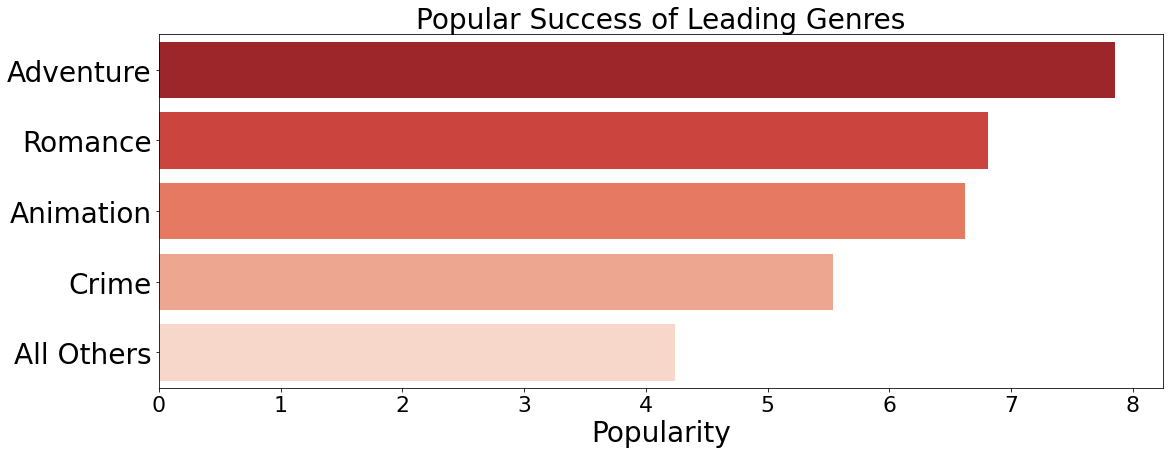

In [18]:
# organize for bar chart
leading_genres.sort_values(by='popularity_mean', 
                           ascending=False, inplace=True)

# declare variables to be graphed
x = leading_genres['genre']
y = leading_genres['popularity_mean']

# declare figure and axis. Set values accordingly.
f, ax = plt.subplots(1, 1, figsize=(18, 6.5), sharex=True)
sns.set_context('talk') 
sns.set_palette("Reds_r")
sns.barplot(data = leading_genres, 
            y = 'genre', 
            x = 'popularity_mean', 
            ax=ax, 
            palette='Reds_r', orient='h')
plt.ylabel('')
plt.xlabel('Popularity', fontsize=28)
#ax.set(xlim=(0,10))
ax.set_title('Popular Success of Leading Genres', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=28)
plt.savefig('images/Popular_Success_of_Leading_Genres.png')
plt.show()

### Now that we know "what is popular", how does popularity affect the profitability of a film?

This portion of the analysis takes a subset of the full movie database, specifically, those within the target genres, and investigates the relationship between profitability and popularity.

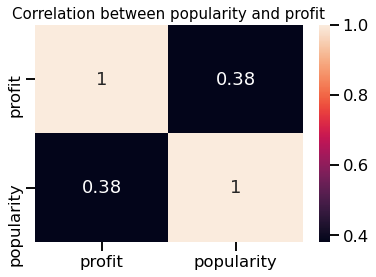

In [19]:
# Create a starting dataframe based off the full dataset
df = all_data.dropna().copy()

# Gather lists of the profit and popularity values for every
# film within the leading genres
prof = []
pop = []
for g in list(leading_genres.genre):
    if g == 'All Others':
        pass
    else:
        x = df.loc[df[g]==True]
        prof.append(list(x['profit']))
        pop.append(list(x['popularity']))

        
# currently formatted as lists of lists. Make each pop and prof
# into their own single-layer lists instead
prof_flat = [val for sublist in prof for val in sublist]
pop_flat = [val for sublist in pop for val in sublist]

 
# remove profit outliers by calculating the std dev and median
profit_std = statistics.pstdev(prof_flat)
profit_med = statistics.median(prof_flat)
profit_lo = profit_med - 3 * profit_std
profit_hi = profit_med + 3 * profit_std
prof_outlier = df.loc[(df['profit'] > profit_hi) | 
            (df['profit'] < profit_lo)]

# remove popularity outliers by calculating the std dev and median
pop_std = statistics.pstdev(pop_flat)
pop_med = statistics.median(pop_flat)
pop_lo = pop_med - 3 * pop_std
pop_hi = pop_med + 3 * pop_std
pop_outlier = df.loc[(df['popularity'] > pop_hi) | 
            (df['popularity'] < pop_lo)]

# remove outliers from the dataset
df = df.drop(pop_outlier.index.append(prof_outlier.index)).copy()
df = df[['profit', 'popularity']].copy()

# plot
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between popularity and profit", fontsize=15)
plt.show()

**Plot this relationship via scatter plot**

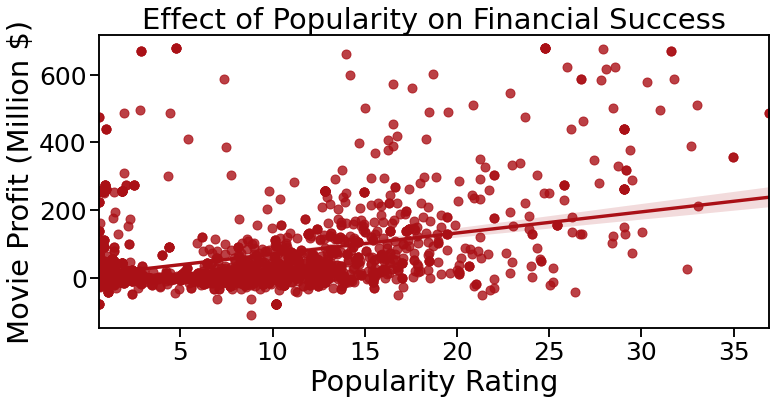

In [20]:
# represent profits in millions for graphical clarity
df['profit'] = df['profit']/10**6

#set themes and create figure
sns.set_context('talk') 
sns.set_palette("Reds_r")
f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

# downsample data a bit to make scatterplot easier to visually interpret
dfSample = df.sample(2500)
xdataSample, ydataSample = dfSample["popularity"], dfSample["profit"]

# produce plot
sns.regplot(x=xdataSample, y=ydataSample, ax=ax) 
plt.xlabel('Popularity Rating', fontsize=29)
plt.ylabel('Movie Profit (Million $)', fontsize=29)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Effect of Popularity on Financial Success', fontsize=29)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('images/Effect_of_Popularity_on_Financial_Success.png')
plt.show()

## Analysis Phase 2: The Impact of the Director

Phase 2 steps away from the genre-focused analysis of Phase 1 and instead looks at the impact a director can have on movie success.

**Basic cleaning of rotten tomatoes datasets**

In [21]:
#minimum number of reviews to be considered
MINIMUM_FRESHOMETER = 5 

# create two dataframes for two separate measures of performance
freshness = pd.DataFrame([rt_reviews.id.unique()], index=['id']).transpose()
rating = pd.DataFrame([rt_reviews.id.unique()], index=['id']).transpose()

for movie_id in freshness['id']:
    fresh =  rt_reviews.loc[rt_reviews['id'] == movie_id, 'fresh']
    rating = rt_reviews.loc[rt_reviews['id'] == movie_id, 'rating']

    review_ct = rt_reviews.loc[rt_reviews['id'] == movie_id, 'fresh'].size
    if  review_ct >= MINIMUM_FRESHOMETER:
        freshness.loc[freshness['id'] == movie_id, 'fresh'] = fresh.mean() 
        freshness.loc[freshness['id'] == movie_id, 'rating'] = rating.mean()

freshness = freshness.dropna()

**Aggregate datasets**

In [22]:
# SQL join of the two Rotten Tomatoes datasets
rt = pysqldf(''' 
SELECT * FROM rt_movie_info
LEFT JOIN freshness USING (id);''')


# if not already a float, remove ',' and convert to float
clean = []
for x in rt['box_office']:
    if type(x) == type('abc'):
        clean.append(float(x.replace(',','')))
    else:
        clean.append(x)

# update column in dataframe with floats
rt['box_office'] = clean

**Aggregate data for each director**

In many cases, there are multiple directors. This loop is necessary to split the string into each director separately. The "counts" values correspond to the number of films directed by the corresponding director.

In [23]:
director_counts_dict = {}
directors = rt['director'].loc[rt['director'].isna()==False]
for name in directors:
    for name_split in name.split(sep = '|'):
        if name_split in director_counts_dict.keys():
            director_counts_dict[name_split] += 1
        else:
            director_counts_dict[name_split] = 1

director_counts_df = pd.Series(director_counts_dict).sort_values(ascending=False)

**Compare the performance of each director to identify the top performers**

The top_directors dataframe contains a list of the top 1000 directors, as provided by TN. It appears their main criteria is the worldwide box office revenue, whereas when considering hiring a director, there are other important aspects. For example, a "one-hit wonder" isn't a great person to put at the helm of the new production, even if their one film did produce well. 

As a metric of overall performance consistency, the list gets narrowed below by saying the director must have produced a proportionally large number of movies. This large number is approximated as anything more than one standard deviation above median. Producing more movies in a measure of bredth of experience relative to peers. 

In [24]:
tn_top_directors

,rank,name,worldwide_box_office,movies,average
0,1,Steven Spielberg,10548165432,36,293004595
1,2,Anthony Russo,6839063507,7,977009072
2,3,Joe Russo,6839063507,8,854882938
3,4,Peter Jackson,6535735207,14,466838229
4,5,Michael Bay,6443668115,16,402729257
...,...,...,...,...,...
995,996,Park Chan-wook,94017407,8,11752176
996,997,Bronwen Hughes,93957800,2,46978900
997,998,Bob Fosse,93623112,4,23405778
998,999,Mike Binder,93561782,8,11695223


In [25]:
top_directors = tn_top_directors.copy()
movies = top_directors.movies
min_movies_to_qualify = movies.std() + movies.median()

# when recommending a top director, it is important 
# that they aren't dead or (i.e. 'out of service'). This is a 
# manually compiled list of directors who appeared at the
# top of the list but who cannot be recommended
OUT_OF_SERVICE = ['Clint Eastwood']

for i, director in enumerate(OUT_OF_SERVICE):
    index_director = top_directors.loc[top_directors.name==OUT_OF_SERVICE[i]].index
    top_directors.drop(index=index_director, inplace=True)

top_directors = top_directors.loc[top_directors['movies'] > min_movies_to_qualify]

# rank the directors into four tiers
# the number assigned to each bucket is less relevant as the
# goal is to show an overall trend
t1 = 5
t2 = 25
t3 = 50
t4 = 100

# place each director into tier 1-4
# based on their worldwide_box_office after having 
# filtered out directors to include those with higher # of films
# directed (i.e. not 'one hit wonders')
tier1 = top_directors.iloc[0: t1]['average'].median()/10**6
tier2 = top_directors.iloc[t1: t2]['average'].median()/10**6
tier3 = top_directors.iloc[t2: t3]['average'].median()/10**6
tier4 = top_directors.iloc[t3:]['average'].median()/10**6

**Plot Findings**

The bar plot shows how drastically the director can impact profit. The table also lists the top five directors, as identified by this analysis.

,Top 5 Directors
1,Steven Spielberg
2,Peter Jackson
3,Michael Bay
4,James Cameron
5,Christopher Nolan


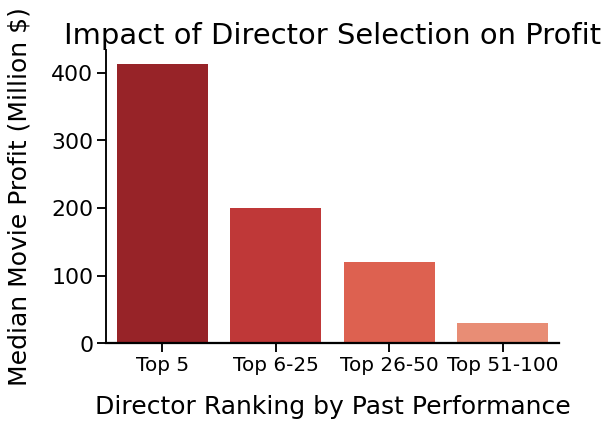

In [26]:
sns.set_context('talk') 
palette = sns.color_palette("Reds_r")
f, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

x = [f'Top {t1}', 
     f'Top {t1+1}-{t2}', 
     f'Top {t2+1}-{t3}', 
     f'Top {t3+1}-{t4}']
y = [tier1, tier2, tier3, tier4]

sns.barplot(x=x, y=y, ax=ax, palette=palette)
ax.axhline(0, color="k", clip_on=False)
ax.set_xlabel('Director Ranking by Past Performance', fontsize=25, labelpad=20)
ax.set_ylabel("Median Movie Profit (Million $)", fontsize=25,  labelpad=20)
ax.set_title('Impact of Director Selection on Profit', fontsize=29)
sns.despine(bottom=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
plt.savefig('images/Impact_of_Director_Selection_on_Profit.png')


ct = 5
table = top_directors[['name']].iloc[:ct]
table.index = range(1,ct+1)
table.columns = [f'Top {ct} Directors']
table

# Next Steps
***

The below steps are essential to verifying the consistency of the findings from this analysis. 

* Evaluate the relationship between profit and popularity based on additional datasets. Rotten Tomatoes and other sources also provide substantial information. Before making a business decision based on the currently moderate correlation, it would be necessary to explore other data sources to see if findings are similar. It is possible the correlation would be notably higher, or perhaps it could be non-existent. As it is a key aspect of the findings, this would be the first additional step to take. 

* Explore the top genres from other data sources. The top genres from Rotten Tomatoes were not studied, and this could be an important aspect to verifying current findings. 

* Other aspects of the films themselves merit study. For example:
    * is the length of the film highly impactful on performance? 
    * despite having a high overall profit, it is possible that some recommended genres cost a prohibitive amount to produce for a company just breaking into the market. Are there any genres that should be removed from consideration based on an intial investment being too high?
    * how does the distribution of performance vary for each genre? If some genres have consistent reliable profits, they may be a more sound choice than genres with extreme highs and lows, as they increase the overall risk exposure to the company. 
    * when recommending the list of top directors, their overall performance history is not an exhaustive metric. It is also essential to look at how that may have changed over time. Did they start out great and deteriorate? Has it been 10 years since they last produced a movie? So far, obviously irrelevant directors such as Client Eastwood have been removed; however, there is room for a deeper investigation here.

# Conclusion
***

Overall, the results show a positive correlation between the impact a genre can have on popularity as well as profitability. The relationship between popularity and profitability was less direct than may have been expected. Specifically, after narrowing to the most valuable genres worth pursuing, the correlation between the two metrics was found to be a moderate 0.38. This varies based on which genres are determined to be top performers, though in most cases they stay within the moderate correlation range. 

It also shows a substantial correlation between the choice of director and the movie profit. A movie directed by one of the top five Directors typically generates over two times the profit of the next 20 top-ranked individuals. Further, the average top 5 director generates over 13 times the profit of the top 50-100 recommended directors. 

The topic being investigated is incredibly complex, and for that reason, much more research is recommended before business strategy decisions are finalized. 